<a href="https://colab.research.google.com/github/HenryZumaeta/py4cd_EPC2025/blob/main/C06/C06_Script01_Merge_Agrupacion_Insight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Modulos y datos
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos (Carguemos en memoria las 8 tablas del esquema estrella (snowflake))
olist_orders = pd.read_csv("https://raw.githubusercontent.com/robintux/Datasets4StackOverFlowQuestions/refs/heads/master/olist_brazil/olist_orders_dataset.csv")
olist_order_items = pd.read_csv("https://raw.githubusercontent.com/robintux/Datasets4StackOverFlowQuestions/refs/heads/master/olist_brazil/olist_order_items_dataset.csv")
olist_order_payments = pd.read_csv("https://raw.githubusercontent.com/robintux/Datasets4StackOverFlowQuestions/refs/heads/master/olist_brazil/olist_order_payments_dataset.csv")
olist_order_reviews = pd.read_csv("https://raw.githubusercontent.com/robintux/Datasets4StackOverFlowQuestions/refs/heads/master/olist_brazil/olist_order_reviews_dataset.csv")
olist_products = pd.read_csv("https://raw.githubusercontent.com/robintux/Datasets4StackOverFlowQuestions/refs/heads/master/olist_brazil/olist_products_dataset.csv")
olist_sellers = pd.read_csv("https://raw.githubusercontent.com/robintux/Datasets4StackOverFlowQuestions/refs/heads/master/olist_brazil/olist_sellers_dataset.csv")
olist_order_customer = pd.read_csv("https://raw.githubusercontent.com/robintux/Datasets4StackOverFlowQuestions/refs/heads/master/olist_brazil/olist_customers_dataset.csv")
olist_geolocation = pd.read_csv("https://raw.githubusercontent.com/robintux/Datasets4StackOverFlowQuestions/refs/heads/master/olist_brazil/olist_geolocation_dataset.csv")

{
    "olist_orders" : olist_orders.columns,
    "olist_order_items" : olist_order_items.columns,
    "olist_order_payments" : olist_order_payments.columns,
    "olist_order_reviews" : olist_order_reviews.columns,
    "olist_products" : olist_products.columns,
    "olist_sellers" : olist_sellers.columns,
    "olist_order_customer" : olist_order_customer.columns,
    "olist_geolocation" : olist_geolocation.columns
}


olist_orders.order_purchase_timestamp = pd.to_datetime(olist_orders.order_purchase_timestamp, format = "%Y-%m-%d %H:%M:%S")


# Extraemos componentes temporales : Creamos columnas derivadas

olist_orders["Year"] = olist_orders.order_purchase_timestamp.dt.year
olist_orders["Month"] = olist_orders.order_purchase_timestamp.dt.month
olist_orders["MonthName"] = olist_orders.order_purchase_timestamp.dt.month_name()
olist_orders["DayOfWeek"] = olist_orders.order_purchase_timestamp.dt.dayofweek
olist_orders["DayName"] = olist_orders.order_purchase_timestamp.dt.day_name()
olist_orders["Hour"] = olist_orders.order_purchase_timestamp.dt.hour
olist_orders["Date"] =  olist_orders.order_purchase_timestamp.dt.date


# Fusionemos los siguientes datasets :
  # olist_orders
  # olist_order_customer

# Fusionar por "customer_id"
df = olist_orders.merge(olist_order_customer, on = "customer_id", how = "inner")

# Análisis 1: Tasa de entrega y geografía

In [3]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'Year', 'Month', 'MonthName', 'DayOfWeek', 'DayName', 'Hour', 'Date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state'],
      dtype='object')

In [4]:
# Objetivo : Responder a la pregunta
# ¿la ubicacion del cliente afecta el tiempo de entrega?

# order_purchase_timestamp : fecha/hora en que el cliente realizo el pedido
# order_delivered_carrier_date : fecha en que el vendedor entrego el paquete al transportista
# order_delivered_customer_date : fecha en que el cliente recibio el producto
# order_estimated_delivery_date : fecha estimada de entrega

# Convertir fechas
cols_date = [
    "order_purchase_timestamp",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
             ]

for col in cols_date:
  df[col] = pd.to_datetime(df[col])

# Validacion
# df.info()

# Calculemos tiempos de entrega

# Cuantas horas pasaron desde que se hizo el pedido hasta que el vendedor lo entrego al transportista
# Tiempo de procesamiento del vendedor
df["delivery_to_carrier_hours"] = (df["order_delivered_carrier_date"] - df["order_purchase_timestamp"]).dt.total_seconds()/3600

# Cuantas horas transcurrieron desde el pedido hasta la entrega final al cliente
# Tiempo total de entrega (vendedor + logistica)
df["delivery_to_customer_hours"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.total_seconds()/3600


# Calculemos si la entrega fue antes, a tiempo o despues de lo que se estimo
df["delivery_delay_hours"] = (df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]).dt.total_seconds()/3600

# Interpretacion de valores en la columna : "delivery_delay_hours"
  # valor positivo : el pedido llego tarde (retraso)
  # valor negativo : el pedido llego antes de lo estimado

# Porcentaje de pedidos que llego tarde
# df[df["delivery_delay_hours"] >0].shape[0]/df.shape[0]*100
df[df["delivery_delay_hours"] >0]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Year,Month,...,DayName,Hour,Date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_to_carrier_hours,delivery_to_customer_hours,delivery_delay_hours
20,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,delivered,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-10-09 22:23:46,2017-09-28,2017,9,...,Monday,14,2017-09-18,d699688533772c15a061e8ce81cb56df,4001,sao paulo,SP,435.309167,511.871111,286.396111
25,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,delivered,2018-02-20 23:46:53,2018-02-22 02:30:46,2018-02-26 22:25:22,2018-03-21 22:03:54,2018-03-12,2018,2,...,Tuesday,23,2018-02-20,a25d5f94840d3c6a1a49f271ed83f4ec,21715,rio de janeiro,RJ,142.641389,694.283611,238.065000
35,8563039e855156e48fccee4d611a3196,5f16605299d698660e0606f7eae2d2f9,delivered,2018-02-17 15:59:46,2018-02-17 16:15:34,2018-02-20 23:03:56,2018-03-20 00:59:25,2018-03-20,2018,2,...,Saturday,15,2018-02-17,92fd8aa5948e20c43a014c44c025c5e1,77480,alvorada,TO,79.069444,728.994167,0.990278
41,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21,2017,11,...,Friday,21,2017-11-24,3e4fd73f1e86b135b9b121d6abbe9597,19400,presidente venceslau,SP,455.771389,813.526389,186.989722
57,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,delivered,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-04-03 13:28:46,2018-04-02,2018,3,...,Friday,14,2018-03-09,ddf60e20e6e262e2136801ce5cd628b0,49030,aracaju,SE,129.684444,598.641944,37.479444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99396,b3112ca67f3afd4e20cf2ee91fc4f804,6f83c71b6c044fb156d697d4130fe9b5,delivered,2018-08-02 22:46:54,2018-08-02 23:04:06,2018-08-15 17:42:00,2018-08-21 00:03:26,2018-08-16,2018,8,...,Thursday,22,2018-08-02,f690f0caffab80b6f849f08ba1692925,9330,maua,SP,306.918333,433.275556,120.057222
99397,0fa1fab1d7c1211c824596ed5e111e3c,7f3bd6c94d2daf7b6462d1a894a775b4,delivered,2018-03-13 21:48:57,2018-03-13 22:40:28,2018-03-14 19:27:23,2018-04-05 19:59:49,2018-04-02,2018,3,...,Tuesday,21,2018-03-13,4b855cb19adce3763ce1af3acc2aae0b,3122,sao paulo,SP,21.640556,550.181111,91.996944
99423,38e9133ce29f6bbe35aed9c3863dce01,ad312389a098ceff46ce92c4595c06d0,delivered,2017-10-12 20:54:11,2017-10-14 03:28:24,2017-10-17 17:04:42,2017-11-21 17:06:59,2017-10-31,2017,10,...,Thursday,20,2017-10-12,a3983b8b6b679c9f645e6ef9517ac98d,14802,araraquara,SP,116.175278,956.213333,521.116389
99425,d692ef54145c9cb3322ec2e5508aa3f4,82ddfcf9438b0cd1117b55ac33184df8,delivered,2018-03-21 19:47:18,2018-03-21 20:05:26,2018-03-22 21:11:58,2018-04-11 00:48:31,2018-04-09,2018,3,...,Wednesday,19,2018-03-21,397cd1affbb66fa8f76e8ac24685440a,13272,valinhos,SP,25.411111,485.020278,48.808611


In [5]:
# Analizar el retraso por estado del cliente (customer_state)
  # Agrupar los datos por estado del cliente
  # calcular el retraso promedio en horas para cada estado
  # ordenar de mayor a menor retraso para ver que estados tienen el peor desempeño

delay_by_state = df.groupby("customer_state")["delivery_delay_hours"].mean().sort_values(ascending=False)
delay_by_state.head(10)

# Interpretacion : No significa que la logistica sea extraordinariamente rapida, sino que la estimacion
# de entrega es muy amplia

,delivery_delay_hours
customer_state,
AL,-192.769413
MA,-213.308267
SE,-223.887396
ES,-235.130613
BA,-242.377742
CE,-242.640162
MS,-248.533390
SP,-249.148549
PI,-255.108916


In [6]:
# Podemos comparar cuantos dias de diferencia hay entre el instan de compra (por parte del cliente)
# y order_estimated_delivery_date
# Mostremos este calculo a nivel de dias y una estadistica descriptiva
(df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]).dt.days.describe()
# Si vez que en promedio hay entre 15-30 dias de estimacion, eso confirma que esa fecha estimada
# fue pronosticada de manera muy conservadora.

,0
count,99441.000000
mean,23.403958
std,8.829562
min,1.000000
25%,18.000000
50%,23.000000
75%,28.000000
max,155.000000


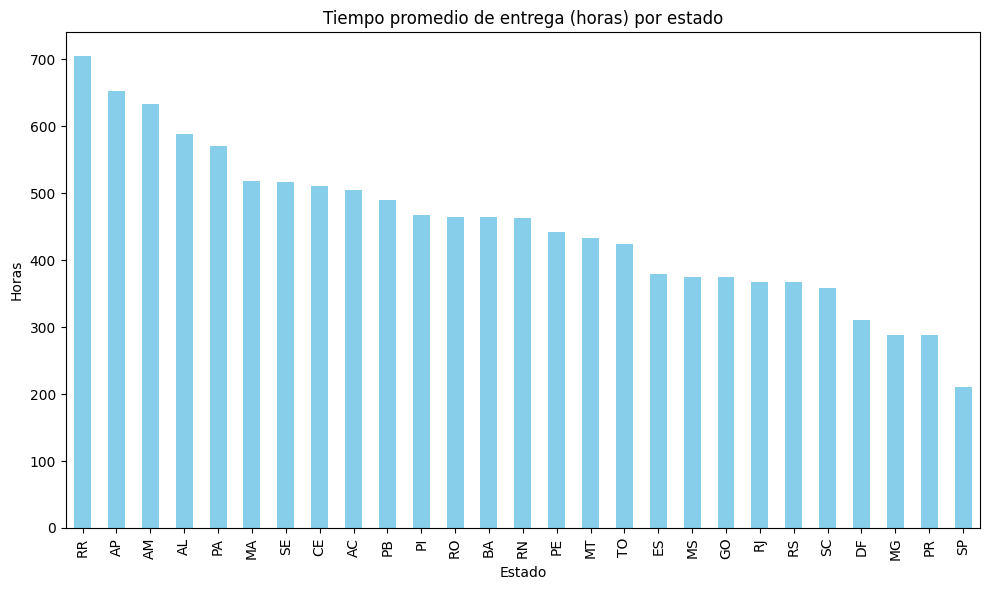

In [7]:
# Analisis el tiempo real de entrega (delivery_to_customer_hours) por estado
# Este es un indicador mas real de desempeño logistico

real_time_by_state = df.groupby("customer_state")["delivery_to_customer_hours"].mean().sort_values(ascending=False)

plt.figure(figsize = (10,6))
real_time_by_state.plot(kind = "bar", color = "skyblue")
plt.title("Tiempo promedio de entrega (horas) por estado")
plt.xlabel("Estado")
plt.ylabel("Horas")

# fin
plt.tight_layout()
plt.show()

In [8]:
# Analisis de la relacion entre el retraso en la entrega y las reseñas de los clientres
# Eso no puede permitir : ¿los clientes que reciben su pedido despues de la fecha estimada tienden
# a dar calificaciones mas bajas?
#
# Esto nos puede ayudar a entender :
  # El impacto del incumplimiento de promesas
  # Si los clientes castigan psicologicamente una entrega tardia, aunque la logistica real haya sido rapida

# Paso1 : Preparar los datos, aseguremonos de tener un dataframe con :
  # informacion de pedidos (order_id, fechas)
  # retraso por horas (delivery_delay_hours)
  # Score de reseña : review_score (olist_order_reviews)

# Unir con reseñar
df_with_reviews = df.merge(olist_order_reviews[["order_id", "review_score"]],
         on = "order_id",
         how = "inner" # solo pedidos con reseña
         )

# Clasificar pedidos como "Tarde" o "A tiempo"
# Definamos
  # "Tarde" : si llego despues de la fecha estimada (delivery_delay_hours > 0)
  # "A tiempo o antes" : delivery_delay_hours <= 0

df_with_reviews["late_delivery"] = df_with_reviews["delivery_delay_hours"] > 0
df_with_reviews["late_delivery"] = df_with_reviews["late_delivery"].map({True: "Con retraso", False : "Sin retraso"})
df_with_reviews["late_delivery"].value_counts()

,count
late_delivery,
Sin retraso,91523
Con retraso,7701


In [9]:
# Comparar puntaje promedio de reseña
df_with_reviews.groupby(["late_delivery"])["review_score"].mean()

,review_score
late_delivery,
Con retraso,2.566550
Sin retraso,4.214307


In [10]:
# Mostremos mas estadisticas de este ultimo calculo
df_with_reviews.groupby(["late_delivery"])["review_score"].agg(["mean", "std", "count"]).round(3)

,mean,std,count
late_delivery,,,
Con retraso,2.567,1.658,7701
Sin retraso,4.214,1.236,91523


/tmp/ipython-input-1580764638.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_with_reviews, x = "late_delivery", y = "review_score", palette = "Set2")


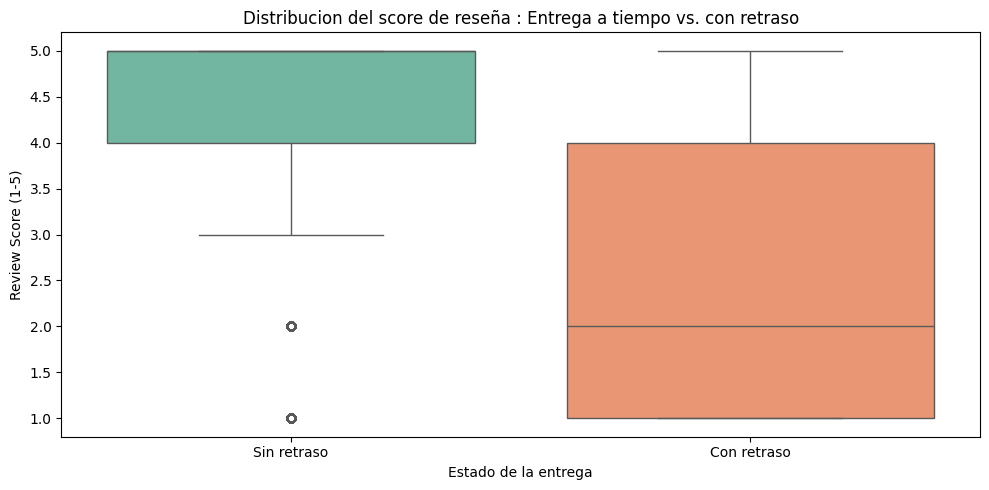

In [11]:
# Distribucion del review_score por retraso
plt.figure(figsize = (10,5))
sns.boxplot(data = df_with_reviews, x = "late_delivery", y = "review_score", palette = "Set2")
plt.title("Distribucion del score de reseña : Entrega a tiempo vs. con retraso")
plt.xlabel("Estado de la entrega")
plt.ylabel("Review Score (1-5)")

# Fin
plt.tight_layout()
plt.show()

# Podemos concluir lo siguiente del boxplot
  # Tenemos outliers (valores atipicos) en las entregas que llegaron a tiempo : Clientes insatisfechos
  # Para los clientes cuyo pedido llego con regresao, observamos una mayor dispersion (mas emocionalidad)
#

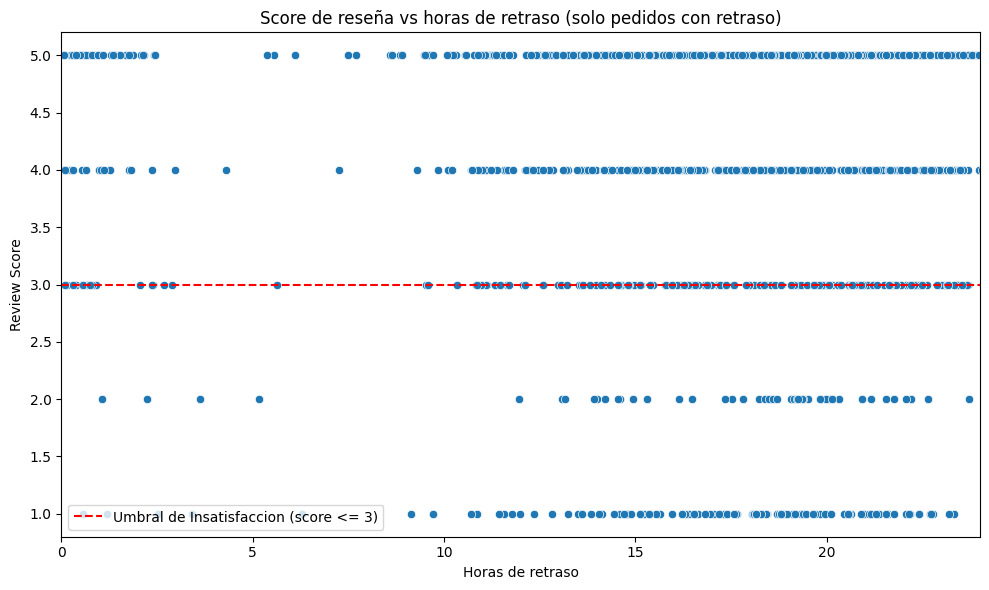

In [12]:
# ¿Cuanto tiempo de retraso genera una mala reseña?
# Analisis de una relacion directa entre las horas de retraso y el score

# Analicemos solo a los pedidos con retraso positivo
delayed_reviews = df_with_reviews[df_with_reviews["delivery_delay_hours"] > 0]

plt.figure(figsize = (10,6))
sns.scatterplot(data = delayed_reviews, x = "delivery_delay_hours", y = "review_score")
plt.title("Score de reseña vs horas de retraso (solo pedidos con retraso)")
plt.xlabel("Horas de retraso")
plt.ylabel("Review Score")
plt.axhline(y = 3, color = "red", linestyle = "--" , label = "Umbral de Insatisfaccion (score <= 3)")
plt.legend()

# Dejemos de lado los outliers extremos
# plt.xlim(0,delayed_reviews["delivery_delay_hours"].quantile(0.9) )
# plt.xlim(delayed_reviews["delivery_delay_hours"].quantile(0.9), delayed_reviews["delivery_delay_hours"].max() )
# plt.xlim(delayed_reviews["delivery_delay_hours"].quantile(0.25),  delayed_reviews["delivery_delay_hours"].quantile(0.75))
plt.xlim(0,24)

# Fin
plt.tight_layout()
plt.show()

In [13]:
# Tasa de malas reseñas (score <= 2) por retraso
# Definamos una mala reseña (score <= 2)
df_with_reviews["bad_review"] = df_with_reviews["review_score"] <= 2

# Tasa de malas reseñas por grupo
bad_review_rate = df_with_reviews.groupby("late_delivery")["bad_review"].mean()*100


# print("Tasa de reseñas malas (score <= 2)")
print(bad_review_rate.round(2))

# Los que reciben su producto tarde tienen casi el quintuple de probabilidad
# de dejar una mala reseña negativa

late_delivery
Con retraso    54.02
Sin retraso    11.38
Name: bad_review, dtype: float64


# Análisis 2: Frecuencia de compra por cliente (RFM)

In [14]:
# Frecuencia de compra por cliente
# Proveer un analisis RFM (Recency, Frequency, Monetary) para segmentar clientes
# por su valor para la empresa (Olist)
  # Recency : ¿Cuando compro por ultima vez?
  # Frequency : ¿Con que frecuencia compra?
  # Monetary : ¿Cuanto dinero a gastado?

# Paso 1 : Asegurarnos/validar que las fechas estan en el formato datetime

# Hacer el merge para conectar pedidos (olist_orders) con clientes (olist_order_customer)
df = olist_orders.merge(olist_order_customer, on = "customer_id", how = "inner")
# Ahora sabemos quien es el cliente (ciudad, estado, codigo postal) detras de cada pedido

# Hacer merge con items (olist_order_items) para obtener precios
df = df.merge(olist_order_items[["order_id", "price", "freight_value"]], on = "order_id", how = "inner")
# Agrega el precio del producto y el valor del envio (freight_value)
# Importante : usar solo las columnas necesarias (por un tema de eficiencia)

# Calculemos el valor total del pedido (precio + envio)
df["total_amount"] = df["price"] + df["freight_value"]

In [16]:
# Paso 2 : Calculo del RFM
# from datetime import datetime

# Fecha de referencia de recencia (fecha mas reciente en los datos + 1dia)
reference_date = df["order_purchase_timestamp"].max() + pd.Timedelta(days = 1)
# Definimos una "fecha de corte" ficticia , un dia despues del ultimo pedido

# Agrupar por cliente unico
rfm = df.groupby("customer_unique_id").agg(
    # Frecuencia
    frequency = ("order_id", "count"),
    # Valor total gastado
    monetary = ("total_amount", "sum"),
    # Ultima compra
    last_purchase = ("order_purchase_timestamp", "max")
).reset_index()



In [17]:
# NUmero de compras en todo df
rfm.frequency.unique()

array([ 1,  2,  4,  3,  7,  5,  6, 12, 10,  8, 18, 15,  9, 14, 11, 21, 20,
       13, 16, 24])

In [18]:
# Cuantos clientes compraron 5 veces
rfm[rfm["frequency"] == 5]

,customer_unique_id,frequency,monetary,last_purchase
260,00ae50eb5e1d2514f694dee1dcbbd5ae,5,276.13,2018-05-10 22:19:03
1026,02c661a1832c392b81d7ba1ebddf8796,5,275.50,2017-09-08 00:59:39
1085,02e9109b7e0a985108b43e573b6afb23,5,602.73,2018-05-14 11:04:55
1118,02ff3aee636a9ee1c1fef271daa0bc07,5,1071.11,2018-03-27 17:19:28
1174,031cc9f0c34aac1349d8a7fca3814d70,5,641.20,2017-10-18 09:57:53
...,...,...,...,...
94345,fd2bf5ffaebabeefee3586c9c3d912e0,5,230.65,2018-05-02 18:38:11
94480,fd849b4fe44dbb27a0ab0d9a0a0562ca,5,235.05,2017-11-30 09:38:21
94490,fd8ccc89be43894d2553494c71a61fd8,5,258.03,2018-04-19 08:19:39
94644,fde5dcb254167dcbac0ba786916bdf75,5,240.65,2018-04-11 08:07:56


In [19]:
# Calcular la recencia en dias
# Cuantos dias han pasado desde la ultima compra del cliente
rfm["recency"] = (reference_date - rfm["last_purchase"]).dt.days

# COmo ya se calculo recency, podemos eliminar la columna last_purchase
rfm.drop("last_purchase", axis = 1, inplace = True)
rfm.sort_values(by = "recency")

,customer_unique_id,frequency,monetary,recency
95083,ff22e30958c13ffe219db7d711e8f564,2,332.92,1
1538,0421e7a23f21e5d54efed456aedbc513,1,119.42,5
13741,24ac2b4327e25baf39f2119e4228976a,1,93.75,5
34576,5c58de6fb80e93396e2f35642666b693,2,510.96,5
12704,21dbe8eabd00b34492a939c540e2b1a7,1,14.29,5
...,...,...,...,...
43183,7390ed59fa1febbfda31a80b4318c8cb,1,154.57,700
5480,0eb1ee9dba87f5b36b4613a65074337c,1,109.34,701
48972,830d5b7aaa3b6f1e9ad63703bec97d23,3,143.46,718
27050,4854e9b3feff728c13ee5fc7d1547e92,1,75.06,729


In [20]:
# Distribucion de clientes por comportamiento
rfm.describe()

# Cuantos clientes : "one-time buyers" (frequency = 1)
# Cual es el gasto promedio
# Cuantos clientes compraron recientemente

# Identificacion de patrones clave
  # frequency alto => cliente leal (recurrente)
  # recency bajo => clientes  activos recientemente
  # monetary alto => Clientes de alto valor (gastadores)
  # recency alto + frequency bajo : Cliente perdido

# Detertar oportunidades de negocio
  # ¿Que porcentaje de clientes compro solo una vez? -> oportunidad de retencion
  # ¿los clientes que gastan mucho vuelven? -> si no, estan siendo mal fidelizados
  # ¿Hay muchos clientes recientes ? -> campaña de segundo pedido

# Preparar una segmentacion avanzada
# De igual manera como los clientes nos asignaron un score (review_score de olist_order_reviews)
# este RFM base sirve para
  # asignar puntajes/score RFM (de 1 a 5) a cada cliente
  # Crear segmentos como
    # Champions : compran seguido, reciente y gastan mucho
    # At Risk : gastaban mucho pero hace tiempo que no compran
    # Potential Loyalists : nuevos pero ya gastaron mucho
    # Lost Customers : hace mucho que compran y compraban poco

,frequency,monetary,recency
count,95420.00000,95420.000000,95420.000000
mean,1.18057,166.040172,243.600377
std,0.62145,228.320333,153.160320
min,1.00000,9.590000,1.000000
25%,1.00000,63.100000,119.000000
50%,1.00000,107.940000,224.000000
75%,1.00000,183.220000,353.000000
max,24.00000,13664.080000,729.000000


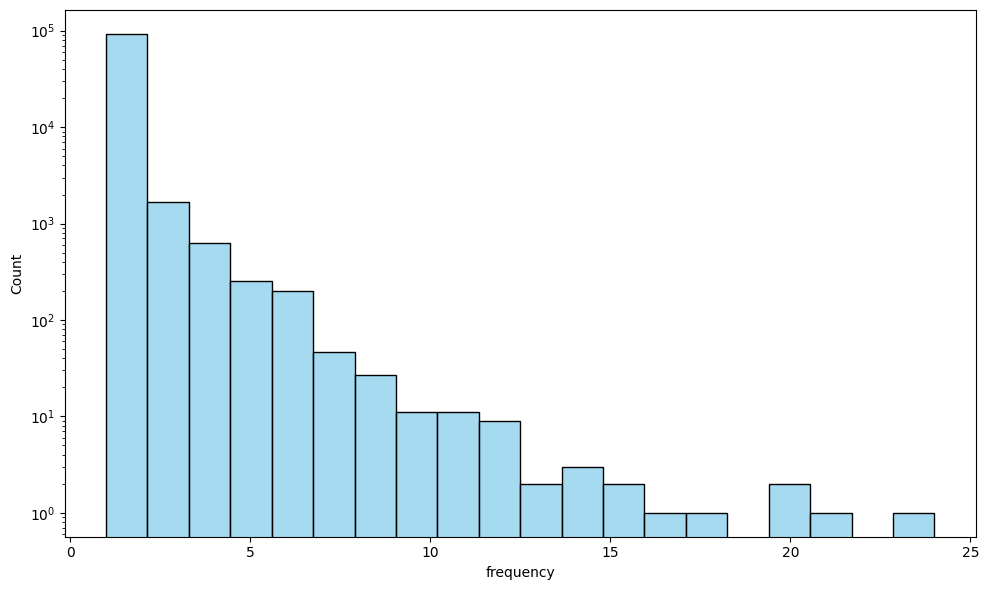

In [21]:
# analisis exploratorio de la frecuencia de compra

plt.figure(figsize= (10,6))
sns.histplot(rfm["frequency"], bins = rfm["frequency"].unique().shape[0], color = "skyblue")

# Cambiemos la escala del eje Y para ver mejor la cola
plt.yscale("log")

# fin
plt.tight_layout()
plt.show()